In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model, metrics
from sklearn.linear_model import LinearRegression
from itertools import combinations
from scipy.optimize import curve_fit

# Regresja liniowa

def linear_regresion(x,y,test_size,random_state):

    x=x.reshape(-1,1)
    regr=linear_model.LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    reg_1 =regr.fit(X_train, y_train) #dopasowanie do danych
    predicted=regr.predict(X_test) #przewidywane wartości
    
    return (regr.coef_[0], metrics.mean_absolute_error(y_test,predicted)) #wspołczynnik nachylenia prostej a i bład a  


def Adzc_regresion(x,y):
#     return np.polyfit(x, np.log(y), 1)
    func = lambda dz, a, c: a * dz**c 
    popt, pcov = curve_fit(func, x, y) # zwraca współczynniki a,c oraz kowariancje
    perr = np.sqrt(np.diag(pcov)) # błędy współczynników
    return popt, perr, func(x, *popt) #zwraca współyczynniki, ich błędy oraz wartości regresji
    

def tylakoidy(path): #wrzuć scieżkę pliku (np. 'C:/Users/Downloads/asd.txt')


    with open (path, 'r') as txt:
        dane =txt.read().splitlines()
        dane=[i.split('\t',2) for i in dane[156:]]


        time =np.array([float(i[0]) for i in dane])
        distance =np.array([float(i[1])*10**6 for i in dane]) # metry zamieniam na mikro metry
        force =np.array([float(i[2]) for i in dane]) # volty

#         błąd pomiaru
        distance_błąd = 5*10**(-4)
        force_błąd = 5*10**(-4)
    
    #     szukam minima i maksima 
        imax=np.where(force==max(force[:1200]))[0][0]
        imin=np.where(force==min(force[:1200]))[0][0]      
        
        
        
#         Wykres siła [V] od distansu
        plt.figure(figsize=(14,14))
        plt.plot(distance[:], force[:],'.',markersize=10)
        plt.legend(fontsize=20)
        plt.xticks(fontsize=25)
        plt.yticks(fontsize=25)
        plt.xlabel('Distance [um]',fontsize=20)
        plt.ylabel('Force [V]',fontsize=20)
        plt.grid()
        plt.title('Krzywe siłowe dla tylakoidów', fontsize=20)
        
        
        
    #     regresja liniowa (nachylenie krzywej kalibracyjnej)
        reg_arg = 20 #Ilość punktów użytych do regresji
        [a, a_błąd]=linear_regresion(distance[imax-reg_arg : imax], force[imax-reg_arg : imax], test_size=0.2, random_state=0)
        
        
        # przeliczam z voltów na niutony i obniżam do 0
        k=0.02
        q = -1/a*k*(10**(-6))*(10**9) #mnożnik do zamiany voltów na niutony
        siła= q *force #nano niutony 
        siła=siła-min(siła[:1200]) 
        siła=siła-siła[imin]

        a_siła = q * a #współczynnik a się skaluje przez mnożnik 



    #     Błąd siły (założenie, że błąd pomiaru siły[V] rożny od 0)
        siła_błąd= lambda x : np.sqrt( ( -k*(10**(-6))*(10**9)*x*(-1/a**2)*a_błąd )**2 + (q*force_błąd)**2 )

    #     Siła adhezji
        imin_all1=np.where(siła==min(siła[-800:-670]))[0][0] # minimum pierwszego 'ząbka'
        imin_all2=np.where(siła==min(siła[-800:-630]))[0][0] # minimum drugiego 'ząbka'
        imin_all3=np.where(siła==min(siła[-800:-550]))[0][0] # minimum trzeciego 'ząbka'
        imin_all4=np.where(siła==min(siła[:]))[0][0] # minimum globalne (minimum czwartego 'ząbka') 

        imax_all12=np.where(siła==max(siła[-690:-670]))[0][0] # max miedzy pierwszym a drugim 'ząbkiem'
        imax_all23=np.where(siła==max(siła[-670:-640]))[0][0] # max miedzy drugim a trzecim 'ząbkiem'
        imax_all34=np.where(siła==max(siła[-600:-550]))[0][0] # max miedzy trzecim a czwartym 'ząbkiem'


        adhezja1 = siła[imax_all12]-siła[imin_all1] 
        adhezja1_błąd = np.sqrt( siła_błąd(force[imin_all1])**2 + siła_błąd(force[imax_all12])**2 )
        adhezja2 = siła[imax_all23]-siła[imin_all2] 
        adhezja2_błąd = np.sqrt( siła_błąd(force[imin_all2])**2 + siła_błąd(force[imax_all23])**2 )
        adhezja3 = siła[imax_all34]-siła[imin_all3] 
        adhezja3_błąd = np.sqrt( siła_błąd(force[imin_all3])**2 + siła_błąd(force[imax_all34])**2 )
        adhezja4 = 0-siła[imin_all4] 
        adhezja4_błąd = siła_błąd(force[imin_all4])

        
        
        adhezje=[['adhezjad1',adhezja1,adhezja1_błąd], ['adhezja2',adhezja2,adhezja2_błąd], ['adhezja3',adhezja3,adhezja3_błąd], ['adhezja4',adhezja4,adhezja4_błąd]]
        comb = list(combinations(adhezje, 2)) # lista 2 elementowych kombinacji
        wielokrotność = []
        
        for i in comb: # i=[ ['adhzja1', adhzja1, blad_adhezja1], ['adhzja2', adhzja2, blad_adhezja2]]
            ad=i[1][1]/i[0][1] #dzielę siły adhezji
            ad_błąd = np.sqrt( (i[1][2]/i[1][1])**2 + (i[0][2]/i[0][1])**2 )
            print(i[1][0],i[0][0],ad,' +- ',ad_błąd)
            if abs(round(ad)-ad) > ad_błąd:  #Czy zaokrąglony iloraz x do jedności jest równy ilorazowi x w granicach błędu ? 
                wielokrotność.append(i[1][0] + ' nie jest wielokrotnością ' + i[0][0]) # nie jest wielokrotnością
            else:
                wielokrotność.append(i[1][0] + ' jest wielokrotnością ' + i[0][0]) #jest wielokrotnością


        

        plt.figure(figsize=(20,20))
        plt.plot(distance[:imax], siła[:imax],'.',markersize=10)
#         plt.plot(distance[imin], siła[imin],'k.',markersize=30)



    #     # linia czarna przerywana
        f0=siła[imin] #podnoszę wartość siły, bo min(siła) jest odstająca od wykresu,  ustawiam punkt zerowy na zagięciu wykresu
        plt.axhline(f0,color='k',ls='--',lw=4, label = 'Linia = 0')

        
        


        # przesunie b  lini kalibracyjnej żółta
#         ustawiam tak aby linia kalibracyjna przecinała oś 0 w punkcie distance[kalib_min]
        kalib_min = imin+35
        kalib_max = kalib_min + 151

        b_siła= siła[kalib_min] -a_siła * distance[kalib_min]
        b_siła_błąd= abs(-a_siła*distance_błąd)
#         b_siła= b_siła  + f0 - (a_siła*( distance[im/in+20] ) +b_siła )
         
    
#         krzyw_kalib = lambda x: a_siła*x +b_siła 
        odwrotna_krzyw_kalib = lambda y: (y - b_siła)/a_siła #y to siła
        odwrotna_krzyw_kalib_błąd = lambda y: np.sqrt( (siła_błąd(y)/a_siła)**2 + (b_siła_błąd/a_siła)**2 ) #y to siła 
#         Używam odwrotnej funkcji krzywej kalibracyjnej, aby wyświetlić odcinek krzywej dla którego liczona jest deltaz
#         Wyrażenie "odwrotna_krzyw_kalib(siła[kalib_min : kalib_max])" zwraca "distance" dla których krzywa kalibracyjna zwraca wartości "siła[kalib_min : kalib_max]"
        plt.plot( odwrotna_krzyw_kalib(siła[kalib_min : kalib_max]) , siła[kalib_min : kalib_max], 'y',linewidth=3, label = 'Linia kalibracyjna')


    
    
        # lina czerwona przeywana
        [A, A_błąd]=linear_regresion(distance[imin-15 : imin], siła[imin-15 : imin], test_size=0.2, random_state=0)
        B=siła[imin]-A*distance[imin]

        plt.plot([distance[imin+50], distance[imin-500]], [ A*distance[imin+50]+B, A*distance[imin-500]+B], 'r--', lw=3, label = 'Linia uśredniająca położenie punktów')

        

        plt.legend(fontsize=20)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel('Distance [um]',fontsize=20)
        plt.ylabel('Force [nN]',fontsize=20)
        plt.grid()
        plt.title('Wykres F (distance)', fontsize=20)


        
        
        
        plt.figure(figsize=(20,20))
        plt.plot(distance[:-400], siła[:-400],'.',markersize=10)

    #     # linia czarna przerywana
        plt.axhline(f0,color='k',ls='--',lw=4, label = 'Linia = 0')


        # krzywa kalibracyjna
        plt.plot( odwrotna_krzyw_kalib(siła[kalib_min : kalib_max]) , siła[kalib_min : kalib_max], 'y',linewidth=3, label = 'Linia kalibracyjna')
    
    
        # lina czerwona przeywana
        plt.plot([distance[imin+50], distance[imin-500]], [ A*distance[imin+50]+B, A*distance[imin-500]+B], 'r--', lw=3, label = 'Linia uśredniająca położenie punktów')

        
        
    #     Strzałka siła adhezji
        plt.annotate(' ', xy = (distance[imin_all1] ,siła[imin_all1]), xytext = (distance[imin_all1], siła[imax_all12]+0.1),
                    arrowprops=dict(facecolor='black',arrowstyle="<->")
                    ,fontsize=16)
        plt.annotate('Siła adhezji 1', xy=( distance[imin_all1] , (siła[imin_all1]-siła[imax_all12])/2),
                ha='left',va='top',fontsize=14,rotation=270
                    )        
        plt.annotate(' ', xy = (distance[imin_all2] ,siła[imin_all2]), xytext = (distance[imin_all2], siła[imax_all23]+0.1),
                    arrowprops=dict(facecolor='black',arrowstyle="<->")
                    ,fontsize=16)
        plt.annotate('Siła adhezji 2', xy=( distance[imin_all2] , (siła[imin_all2]-siła[imax_all23])/2),
                ha='left',va='top',fontsize=14,rotation=270
                    )    
        plt.annotate(' ', xy = (distance[imin_all3] ,siła[imin_all3]), xytext = (distance[imin_all3], siła[imax_all34]+0.1),
                    arrowprops=dict(facecolor='black',arrowstyle="<->")
                    ,fontsize=16)
        plt.annotate('Siła adhezji 3', xy=( distance[imin_all3], (siła[imin_all3]-siła[imax_all34])/2),
                ha='left',va='top',fontsize=14,rotation=270
                    )    
        plt.annotate(' ', xy = (distance[imin_all4] ,siła[imin_all4]), xytext = (distance[imin_all4], 0.05),
                    arrowprops=dict(facecolor='black',arrowstyle="<->")
                    ,fontsize=16)
        plt.annotate('Siła adhezji 4', xy=( distance[imin_all4], siła[imin_all4]/2),
                ha='left',va='top',fontsize=14,rotation=270
                    )    
        
        
        
        plt.legend(fontsize=20)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel('Distance [um]',fontsize=20)
        plt.ylabel('Force [nN]',fontsize=20)
        plt.grid()
        plt.title('Wykres F (distance)', fontsize=20)


        
        

        # indentacja
        deltaz =  abs( odwrotna_krzyw_kalib (siła[kalib_min : kalib_max])  - distance[kalib_min : kalib_max] ) 
        

        # średnie deltaz
        mean_deltaz = np.mean(deltaz)

        # Błąd deltaz (przyjąłem 0.5%)
        deltaz_błąd= np.sqrt( odwrotna_krzyw_kalib_błąd(force[kalib_min : kalib_max])**2 + distance_błąd**2 )
        deltaz_średni_błąd = np.mean(deltaz_błąd)
        
        # Regresja A*dz^c 
        [coef_reg, coef_reg_błąd, y_reg] = Adzc_regresion(deltaz, siła[kalib_min : kalib_max])
        
    #     kreśle wykres F(dz)
        plt.figure(figsize=(13,8))
        plt.title('Wykres siły od indentacji: F($\Delta$z)', fontsize=20)
        plt.plot(deltaz, siła[kalib_min : kalib_max],'.', markersize=10, label='Wyniki')
        plt.plot(deltaz, y_reg + min( siła[kalib_min : kalib_max] ),'r-', markersize=10, label='Krzywa teoretyczna')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.xlabel('$\Delta$z [$\mu$m]',fontsize=17)
        plt.ylabel('Siła [nN]',fontsize=17)
        plt.legend(fontsize=20)
        plt.grid()
        

        # A = F(dz) / dz^2
        mean_A = coef_reg[0]

        # średni błąd A (z prawa przenoszenia niepewności)
        A_średni_błąd = coef_reg_błąd[0]


        #  moduł elastyczności Ek
        uk = 0.5
        alfa = 25
        Ek = ( np.pi * (1 - uk**2) / ( 2 * np.tan(alfa * np.pi/180))) * mean_A 
        # błąd Ek (z prawa przenoszenia niepewności)
        Ek_błąd= abs( np.pi * (1 - uk**2) / ( 2 * np.tan(alfa * np.pi/180)) * A_średni_błąd )



        print(f'Siła[V] max = \t\t\t\t{force[imax]} +- {force_błąd}\nSiła[V] min = \t\t\t\t{force[imin]} +- {force_błąd}\nWspółczynnik linii kalibracyjnej a = \t{a} +- {a_błąd}')
        print(f'Siła adhezji 1 [nN] = \t\t\t{adhezja1} +- {adhezja1_błąd}\nSiła adhezji 2 [nN] = \t\t\t{adhezja2} +- {adhezja2_błąd}')
        print(f'Siła adhezji 3 [nN] = \t\t\t{adhezja3} +- {adhezja3_błąd}\nSiła adhezji 4 [nN] = \t\t\t{adhezja4} +- {adhezja4_błąd}')
        print(f'Współczynnik regresji A*dz^c : \n\t\t\t\tA \t{coef_reg[0]} +- {coef_reg_błąd[0]}\n\t\t\t\tc \t{coef_reg[1]} +- {coef_reg_błąd[1]}')
        for i in wielokrotność:
            print(i)
        print(f'Współczynnik sprężystości k = \t\t{k}\nŚrednie delta z = \t\t\t{mean_deltaz} +- {deltaz_średni_błąd}')
        print(f'Średni moduł elastyczności A = \t\t{mean_A} +- {A_średni_błąd}\nModuł Younga Ek = \t\t\t{Ek} +- {Ek_błąd}')

No handles with labels found to put in legend.


adhezja2 adhezjad1 1.5202312138728304  +-  0.00989721147278017
adhezja3 adhezjad1 3.1705202312138594  +-  0.0086743925350779
adhezja4 adhezjad1 6.231213872832356  +-  0.008323986137082757
adhezja3 adhezja2 2.0855513307984728  +-  0.0060362634320353945
adhezja4 adhezja2 4.098859315589349  +-  0.005520881775464718
adhezja4 adhezja3 1.965360072926166  +-  0.002787548473899994


<ipython-input-1-63d9d1765f6f>:24: RuntimeWarning: divide by zero encountered in power
  func = lambda dz, a, c: a * dz**c


Siła[V] max = 				-1.97113037109375 +- 0.0005
Siła[V] min = 				-6.1767578125 +- 0.0005
Współczynnik linii kalibracyjnej a = 	-11.0442781220176 +- 0.0006103515625
Siła adhezji 1 [nN] = 			0.19121362056610458 +- 0.0015812071835927303
Siła adhezji 2 [nN] = 			0.290688914502228 +- 0.0015807996901454826
Siła adhezji 3 [nN] = 			0.6062466524884851 +- 0.001588248628160143
Siła adhezji 4 [nN] = 			1.191492965146013 +- 0.0011347636167846986
Współczynnik regresji A*dz^c : 
				A 	487.5078272853667 +- 52.38118754563809
				c 	2.299824128678178 +- 0.04981336313798792
adhezja2 nie jest wielokrotnością adhezjad1
adhezja3 nie jest wielokrotnością adhezjad1
adhezja4 nie jest wielokrotnością adhezjad1
adhezja3 nie jest wielokrotnością adhezja2
adhezja4 nie jest wielokrotnością adhezja2
adhezja4 nie jest wielokrotnością adhezja3
Współczynnik sprężystości k = 		0.02
Średnie delta z = 			0.08363189534580782 +- 0.0007090029075608934
Średni moduł elastyczności A = 		487.5078272853667 +- 52.38118754563809
M

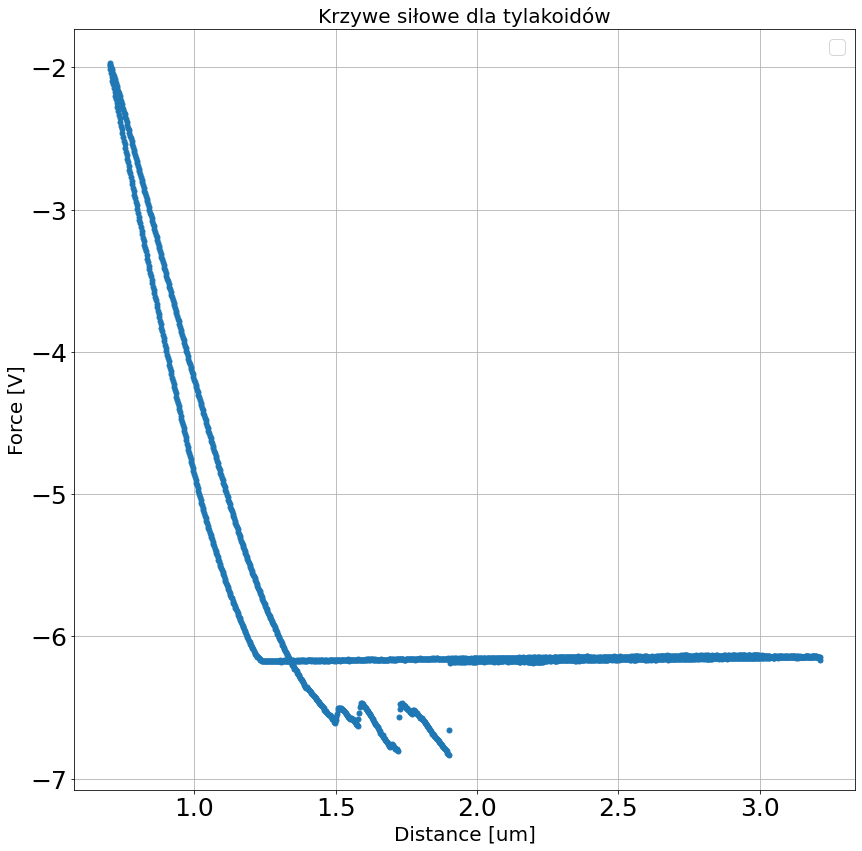

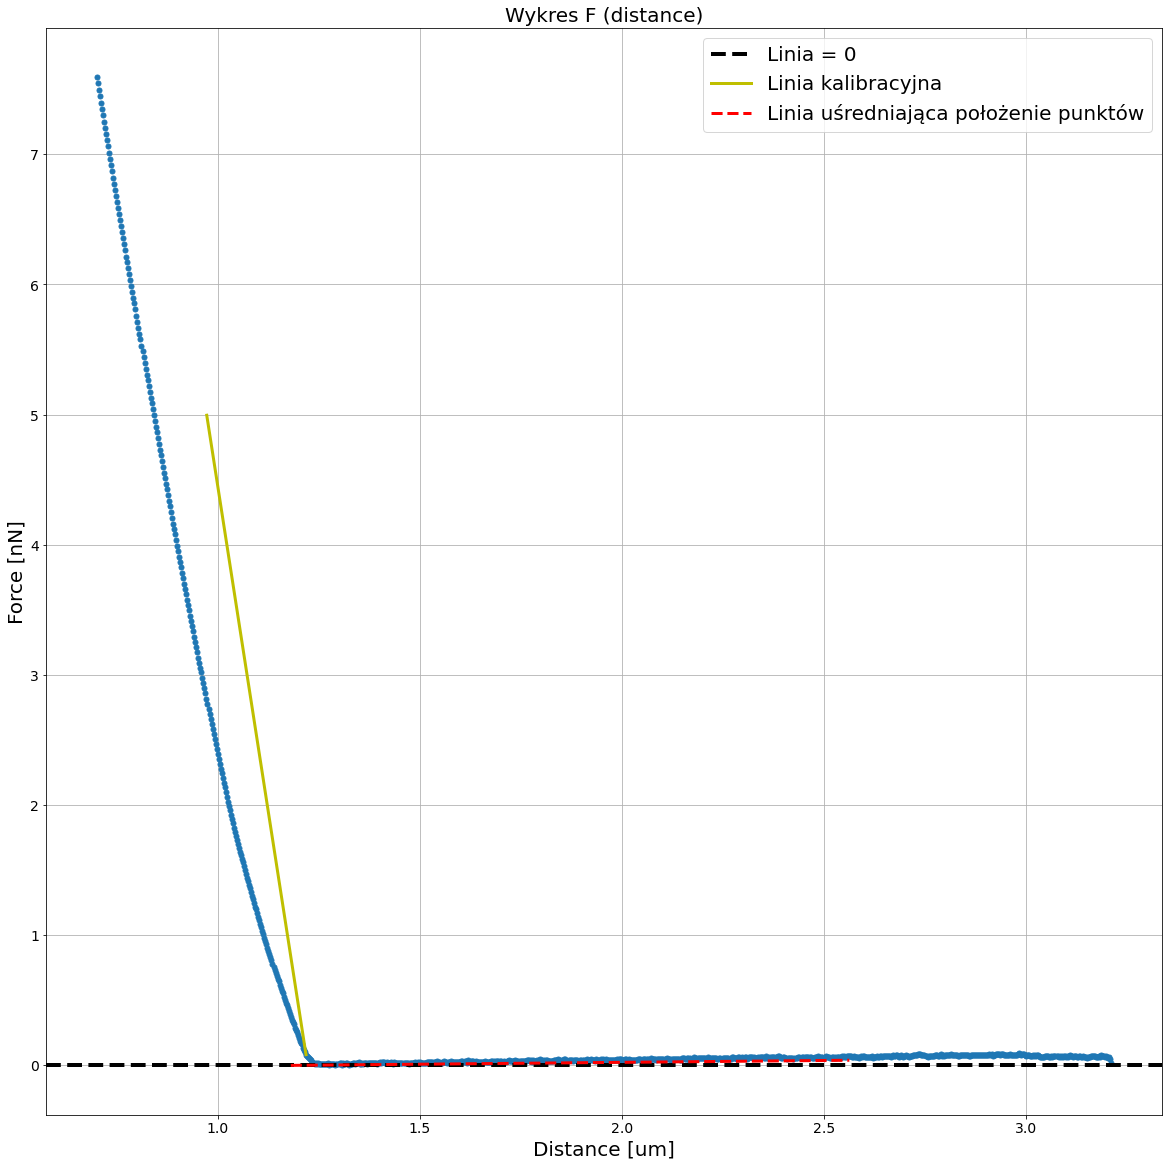

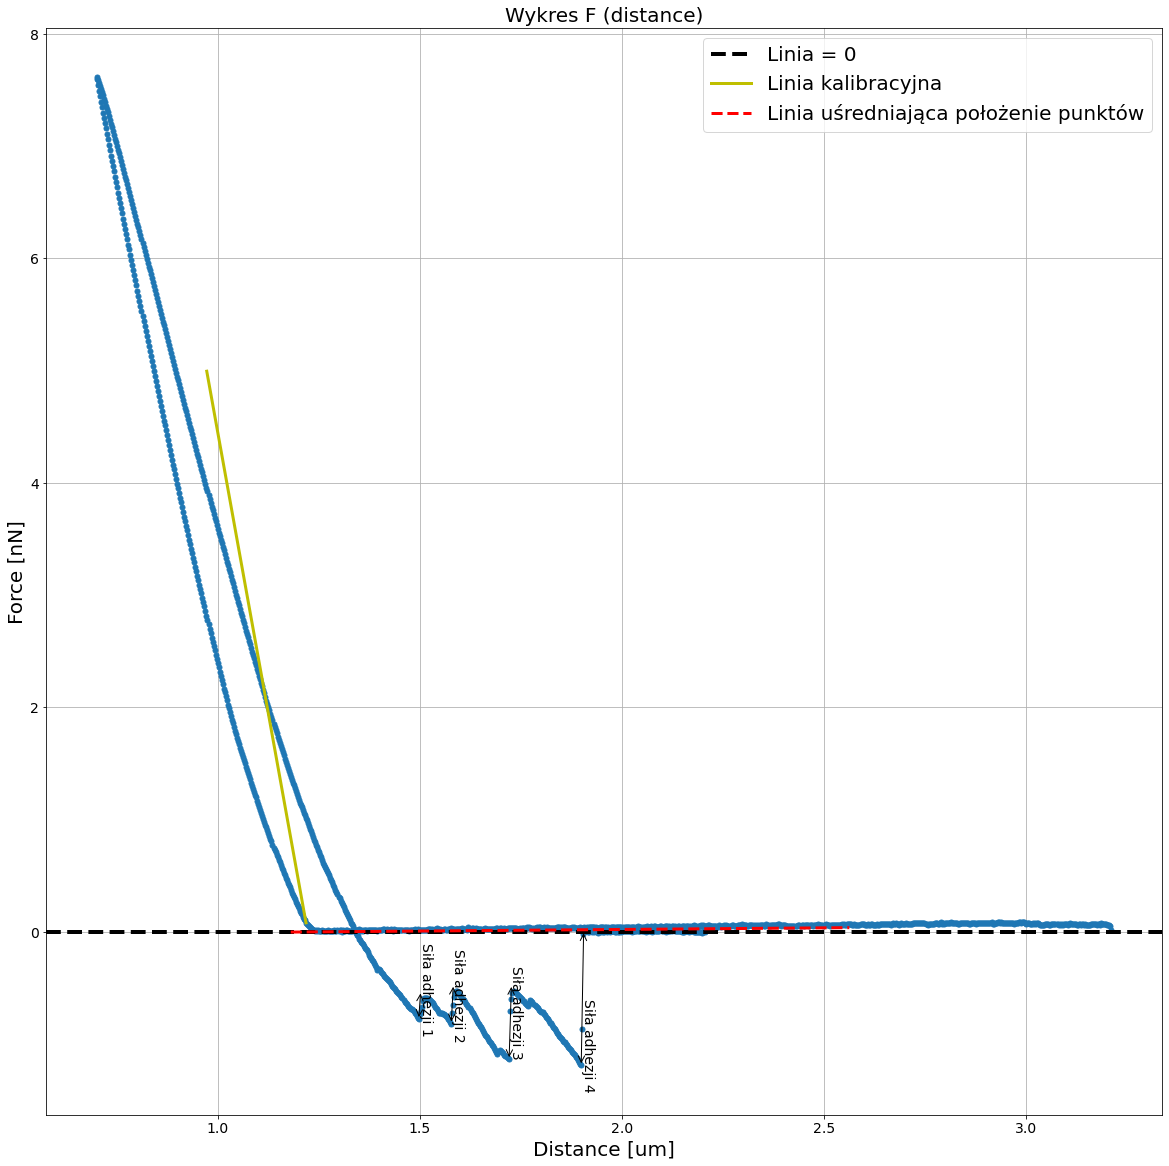

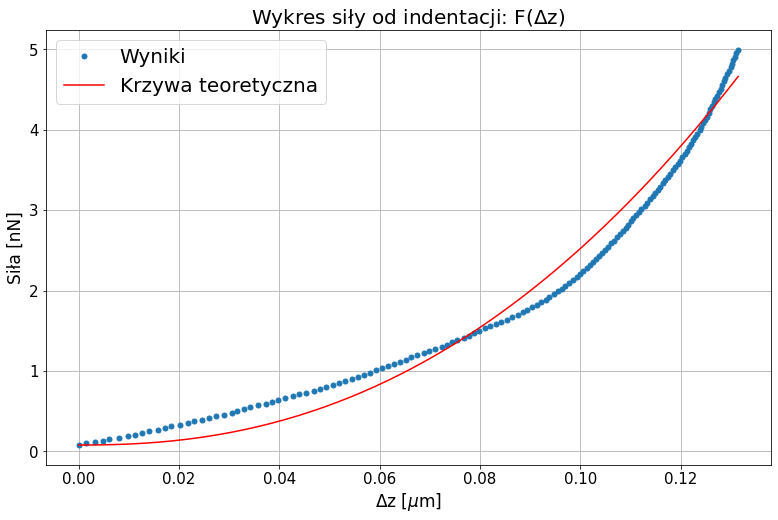

In [2]:
tylakoidy('C:/Users/barte/Downloads/B_Klima_tylakoidy.txt')